# Study on eSNLI

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
import os
from os import path

import sys
sys.path.append("./../src")

cache_path = path.join(os.getcwd(), '..', '.cache')

DATASET_NAME='esnli'

dataset_path = path.join(cache_path, 'dataset', DATASET_NAME)

tmp_path = path.join('.cache', '2022-09-03')
os.makedirs(tmp_path,exist_ok=True)

In [2]:
from data.esnli.dataset import ESNLI

dataset = ESNLI('test', root=cache_path+'/dataset')
dataset.data

AssertionError: /home/dunguyen/explanation_on_pair_sequences_task/notebooks/../.cache/dataset/esnli/_esnli.zip

In [3]:
from data.esnli.pipeline import PretransformedESNLI
from data.esnli.transforms import HighlightTransform, HeuristicTransform
from data.transforms import LemmaLowerTokenizerTransform
from torchtext.vocab import GloVe
import torchtext.transforms as T
import spacy

spacy_model = spacy.load('en_core_web_sm')
tokenizer_transform = LemmaLowerTokenizerTransform(spacy_model)

hl_transform = T.Sequential(
    tokenizer_transform,
    HighlightTransform()
)

heuristic_transform = HeuristicTransform(
    vectors=GloVe(cache=path.join(cache_path, 'models', '.vector_cache')),
    spacy_model=spacy_model
)

transformations = {
    'premise': tokenizer_transform,
    'hypothesis': tokenizer_transform,
    'highlight_premise': hl_transform,
    'highlight_hypothesis': hl_transform,
    'heuristic': heuristic_transform,
}

trans_columns = {
    'premise': 'tokens.norm.premise',
    'hypothesis': 'tokens.norm.hypothesis',
    'highlight_premise': 'rationale.premise',
    'highlight_hypothesis': 'rationale.hypothesis',
    'heuristic': 'heuristic'
}

testset = PretransformedESNLI(transformations, trans_columns, split='test', root=cache_path+'/dataset')
testset.data

,id,premise,hypothesis,label,explanation,highlight_premise,highlight_hypothesis,tokens.norm.premise,tokens.norm.hypothesis,rationale.premise,rationale.hypothesis,heuristic.premise,heuristic.hypothesis,tokens.form.premise,tokens.form.hypothesis
0,2677109430.jpg#1r1n,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,neutral,Not all churches have cracks in the ceiling,This church choir sings to the masses as they ...,The church has *cracks* *in* *the* *ceiling.*,"[this, church, choir, sing, to, the, masse, as...","[the, church, have, crack, in, the, ceiling, .]","[False, False, False, False, False, False, Fal...","[False, False, False, True, True, True, True, ...","[-1.0000000150474662e+30, 3.064525842666626, 1...","[-1.0000000150474662e+30, 7.628961086273193, -...","[This, church, choir, sings, to, the, masses, ...","[The, church, has, cracks, in, the, ceiling, .]"
1,2677109430.jpg#1r1e,This church choir sings to the masses as they ...,The church is filled with song.,entailment,"""Filled with song"" is a rephrasing of the ""cho...",This church *choir* *sings* *to* *the* *masses...,The church is *filled* *with* *song.*,"[this, church, choir, sing, to, the, masse, as...","[the, church, be, fill, with, song, .]","[False, False, True, True, True, True, True, F...","[False, False, False, True, True, True, False]","[-1.0000000150474662e+30, 2.79181170463562, 2....","[-1.0000000150474662e+30, 7.628961086273193, -...","[This, church, choir, sings, to, the, masses, ...","[The, church, is, filled, with, song, .]"
2,2677109430.jpg#1r1c,This church choir sings to the masses as they ...,A choir singing at a baseball game.,contradiction,A choir sing some other songs other than book ...,This church choir sings to the *masses* as the...,A choir *singing* at a *baseball* *game.*,"[this, church, choir, sing, to, the, masse, as...","[a, choir, singing, at, a, baseball, game, .]","[False, False, False, False, False, False, Tru...","[False, False, True, False, False, True, True,...","[-1.0000000150474662e+30, 2.5598971843719482, ...","[-1.0000000150474662e+30, 6.388305187225342, 6...","[This, church, choir, sings, to, the, masses, ...","[A, choir, singing, at, a, baseball, game, .]"
3,6160193920.jpg#4r1n,"A woman with a green headscarf, blue shirt and...",The woman is young.,neutral,the woman could've been old rather than young,"A woman with a green headscarf, blue shirt and...",The woman is *young.*,"[a, woman, with, a, green, headscarf, ,, blue,...","[the, woman, be, young, .]","[False, False, False, False, False, False, Fal...","[False, False, False, True, False]","[-1.0000000150474662e+30, 2.597653388977051, -...","[-1.0000000150474662e+30, 5.648240089416504, -...","[A, woman, with, a, green, headscarf, ,, blue,...","[The, woman, is, young, .]"
4,6160193920.jpg#4r1e,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,entailment,a grin suggests hapiness.,"A woman with a green headscarf, blue shirt and...",The woman is very *happy.*,"[a, woman, with, a, green, headscarf, ,, blue,...","[the, woman, be, very, happy, .]","[False, False, False, False, False, False, Fal...","[False, False, False, False, True, False]","[-1.0000000150474662e+30, 2.784580707550049, -...","[-1.0000000150474662e+30, 5.648240089416504, -...","[A, woman, with, a, green, headscarf, ,, blue,...","[The, woman, is, very, happy, .]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9819,4378810163.jpg#4r1c,Two women are observing something together.,Two women are standing with their eyes closed.,contradiction,Answer: The women cannot be observing with eye...,Two women are *observing* something together.,Two women are standing with their *eyes* *clos...,"[two, woman, be, observe, something, together, .]","[two, woman, be, stand, with, their, eye, clos...","[False, False, False, True, False, False, False]","[False, False, False, False, False, False, Tru...","[-1.0000000150474662e+30, 3.7125906944274902, ...

In [5]:
for side in ['premise', 'hypothesis']:
    print('tokens vs heuristic:', (testset.data[f'tokens.norm.{side}'].str.len() == testset.data[f'heuristic.{side}'].str.len()).all())
    print('tokens vs rationales: ', (testset.data[f'tokens.norm.{side}'].str.len() == testset.data[f'rationale.{side}'].str.len()).all())

tokens vs heuristic: True
tokens vs rationales:  True
tokens vs heuristic: True
tokens vs rationales:  True


## Statistic on tokens

In [ ]:
trainset = PretransformedESNLI(transformations, trans_columns, split='train', root=cache_path+'/dataset')

In [ ]:
valset = PretransformedESNLI(transformations, trans_columns, split='val', root=cache_path+'/dataset')

In [ ]:
import pandas as pd
fulldata = pd.concat([trainset.data, valset.data, testset.data], ignore_index=True)

In [ ]:
fulldata['premise_tokens'].str.len().describe()

In [ ]:
fulldata['hypothesis_tokens'].str.len().describe()

## Statistic on POS tags

Count in test set

In [4]:
from spacy.tokens import Doc
import spacy

# Load test set in dataframe
df = testset.data

# Concat both premise and hypothesis
df['tokens.norm'] = df.apply(lambda x: x['tokens.norm.premise'] + x['tokens.norm.hypothesis'], axis=1)
df['rationale'] = df.apply(lambda x: x['rationale.premise'] + x['rationale.hypothesis'], axis=1)

# Flatten into single vector
tokens = df['tokens.norm'].tolist()
rationales = df['rationale'].tolist()
flat_token = [t for sent in tokens for t in sent]
flat_rationale = [r for sent in rationales for r in sent]

# Convert into spacy to get Pos tag
nlp = spacy.load('en_core_web_sm')
doc = Doc(nlp.vocab, words=flat_token)
pos = [tk.pos_ for tk in nlp(doc)]

# Counting in general
cnt = {
    'annotation': dict(),
    'dataset' : dict()
}

for p, r in zip(pos, flat_rationale):
    cnt['dataset'][p] = cnt['dataset'].get(p, 0) + 1
    if r:
        cnt['annotation'][p] = cnt['annotation'].get(p, 0) + 1
        
cnt

{'annotation': {'NOUN': 20057,
  'ADP': 3767,
  'DET': 3390,
  'VERB': 6634,
  'ADJ': 4235,
  'ADV': 876,
  'AUX': 527,
  'CCONJ': 270,
  'PROPN': 611,
  'NUM': 754,
  'PART': 332,
  'SCONJ': 97,
  'PRON': 805,
  'PUNCT': 2,
  'X': 10,
  'INTJ': 10},
 'dataset': {'DET': 39607,
  'NOUN': 70019,
  'VERB': 21509,
  'ADP': 29167,
  'SCONJ': 1790,
  'PRON': 6000,
  'ADJ': 17922,
  'PUNCT': 20907,
  'AUX': 10108,
  'CCONJ': 4367,
  'ADV': 2938,
  'PART': 1543,
  'PROPN': 2272,
  'NUM': 4023,
  'INTJ': 44,
  'X': 22,
  'SPACE': 17,
  'SYM': 3}}

AttributeError: module 'matplotlib.pyplot' has no attribute 'fontsize'

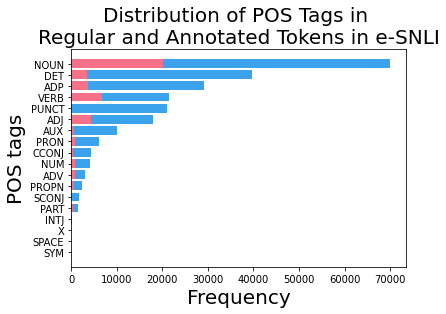

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.color_palette("husl", 3)

# Sort value for display
cnt['dataset'] = {k: v for k, v in sorted(cnt['dataset'].items(), key=lambda item: item[1])}
       
plt.barh(list(cnt['dataset'].keys()), list(cnt['dataset'].values()), color = palette[2], label='Dataset')
plt.barh(list(cnt['annotation'].keys()), list(cnt['annotation'].values()), color = palette[0], label='Annotated')
#labels = list(colors.keys())

plt.rc('axes', titlesize=10, labelsize=20)

plt.title('Distribution of POS Tags in \nRegular and Annotated Tokens in e-SNLI', fontsize=20)
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('POS tags', fontsize=20)
plt.fontsize(20)
plt.legend()
plt.show()

In [151]:
# Concat both premise and hypothesis
df_ent = df[df['label'] == 'entailment'].reset_index()
df_ent['tokens.norm'] = df_ent.apply(lambda x: x['tokens.norm.premise'] + x['tokens.norm.hypothesis'], axis=1)
df_ent['rationale'] = df_ent.apply(lambda x: x['rationale.premise'] + x['rationale.hypothesis'], axis=1)

# Flatten into single vector
tokens = df_ent['tokens.norm'].tolist()
rationales = df_ent['rationale'].tolist()
flat_token = [t for sent in tokens for t in sent]
flat_rationale = [r for sent in rationales for r in sent]

# Convert into spacy to get Pos tag
nlp = spacy.load('en_core_web_sm')
doc = Doc(nlp.vocab, words=flat_token)
pos = [tk.pos_ for tk in nlp(doc)]

# Counting in general
cnt_ent = {
    'annotation': dict(),
    'dataset' : dict()
}

for p, r in zip(pos, flat_rationale):
    cnt_ent['dataset'][p] = cnt_ent['dataset'].get(p, 0) + 1
    if r:
        cnt_ent['annotation'][p] = cnt_ent['annotation'].get(p, 0) + 1
        
cnt_ent

{'annotation': {'NOUN': 9933,
  'VERB': 2779,
  'ADP': 1878,
  'DET': 1749,
  'ADJ': 1921,
  'AUX': 305,
  'PROPN': 238,
  'CCONJ': 151,
  'ADV': 498,
  'NUM': 467,
  'PART': 97,
  'PRON': 337,
  'SCONJ': 41,
  'X': 3,
  'INTJ': 4,
  'PUNCT': 1},
 'dataset': {'DET': 13230,
  'NOUN': 23413,
  'VERB': 7127,
  'ADP': 9719,
  'SCONJ': 560,
  'PRON': 1962,
  'ADJ': 6019,
  'PUNCT': 7181,
  'AUX': 3394,
  'CCONJ': 1506,
  'ADV': 1117,
  'PART': 437,
  'PROPN': 695,
  'NUM': 1429,
  'INTJ': 12,
  'X': 6,
  'SPACE': 6,
  'SYM': 1}}

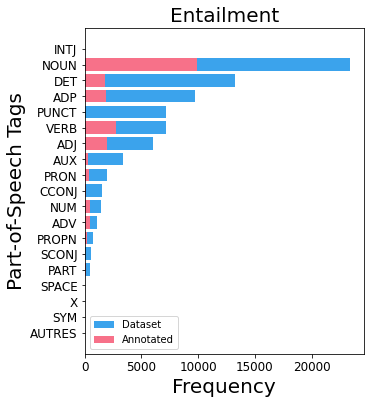

In [139]:
# Sort value for display
cnt_ent['dataset'] = {k: v for k, v in sorted(cnt_ent['dataset'].items(), key=lambda item: item[1])}

plt.figure(figsize=(5,6)) 
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.barh(list(cnt_ent['dataset'].keys()), list(cnt_ent['dataset'].values()), color = palette[2], label='Dataset')
plt.barh(list(cnt_ent['annotation'].keys()), list(cnt_ent['annotation'].values()), color = palette[0], label='Annotated')

plt.title('Entailment', fontsize=20)
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Part-of-Speech Tags', fontsize=20)
plt.legend()
plt.savefig(path.join(tmp_path, 'stats_pos_esnli_contra.png'), bbox_inches="tight", dpi=300)
plt.show()

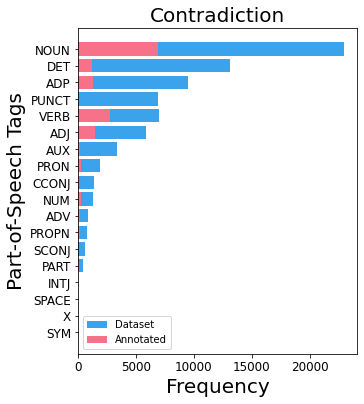

In [73]:
# Sort value for display

# Follow entailemnt
cnt_con['dataset'] = {k: cnt_con['dataset'][k] for k in cnt_ent['dataset'].keys()}
       
plt.figure(figsize=(5,6))    

plt.barh(list(cnt_con['dataset'].keys()), list(cnt_con['dataset'].values()), color = palette[2], label='Dataset')
plt.barh(list(cnt_con['annotation'].keys()), list(cnt_con['annotation'].values()), color = palette[0], label='Annotated')

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)


plt.title('Contradiction', fontsize=20)
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Part-of-Speech Tags', fontsize=20)
plt.legend()
plt.savefig(path.join(tmp_path, 'stats_pos_esnli_contra.png'), bbox_inches="tight", dpi=300)
plt.show()

In [70]:
# Concat both premise and hypothesis

stats = []

for label in ['entailment', 'contradiction']:
    print(f'Counting {label}')
    df_label = df[df['label'] == label].reset_index()
    df_label['tokens.norm'] = df_label.apply(lambda x: x['tokens.norm.premise'] + x['tokens.norm.hypothesis'], axis=1)
    df_label['rationale'] = df_label.apply(lambda x: x['rationale.premise'] + x['rationale.hypothesis'], axis=1)

    # Flatten into single vector
    tokens = df_label['tokens.norm'].tolist()
    rationales = df_label['rationale'].tolist()
    flat_token = [t for sent in tokens for t in sent]
    flat_rationale = [r for sent in rationales for r in sent]

    # Convert into spacy to get Pos tag
    nlp = spacy.load('en_core_web_sm')
    doc = Doc(nlp.vocab, words=flat_token)
    pos = [tk.pos_ for tk in nlp(doc)]

    # Counting in general
    
    cnt = {
        'annotation': dict(),
        'dataset' : dict()
    }

    for p, r in zip(pos, flat_rationale):
        cnt['dataset'][p] = cnt['dataset'].get(p, 0) + 1
        if r:
            cnt['annotation'][p] = cnt['annotation'].get(p, 0) + 1

    stats.append({
        'label': label,
        **cnt
    })

stats

Counting entailment
Counting contradiction


[{'label': 'entailment',
  'annotation': {'NOUN': 9933,
   'VERB': 2779,
   'ADP': 1878,
   'DET': 1749,
   'ADJ': 1921,
   'AUX': 305,
   'PROPN': 238,
   'CCONJ': 151,
   'ADV': 498,
   'NUM': 467,
   'PART': 97,
   'PRON': 337,
   'SCONJ': 41,
   'X': 3,
   'INTJ': 4,
   'PUNCT': 1},
  'dataset': {'DET': 13230,
   'NOUN': 23413,
   'VERB': 7127,
   'ADP': 9719,
   'SCONJ': 560,
   'PRON': 1962,
   'ADJ': 6019,
   'PUNCT': 7181,
   'AUX': 3394,
   'CCONJ': 1506,
   'ADV': 1117,
   'PART': 437,
   'PROPN': 695,
   'NUM': 1429,
   'INTJ': 12,
   'X': 6,
   'SPACE': 6,
   'SYM': 1}},
 {'label': 'contradiction',
  'annotation': {'NOUN': 6907,
   'ADJ': 1447,
   'ADV': 196,
   'VERB': 2734,
   'ADP': 1329,
   'CCONJ': 90,
   'PROPN': 213,
   'DET': 1178,
   'NUM': 234,
   'PRON': 241,
   'AUX': 136,
   'PUNCT': 1,
   'PART': 97,
   'X': 6,
   'SCONJ': 15,
   'INTJ': 2},
  'dataset': {'DET': 13125,
   'NOUN': 22929,
   'VERB': 7005,
   'ADP': 9536,
   'SCONJ': 571,
   'PRON': 1867,
   'ADJ

In [71]:
# sort by values in entailment
stats_ent = stats[0]
stats[0]['dataset'] = {k: v for k, v in sorted(stats_ent['dataset'].items(), key=lambda item: item[1])}

In [72]:
# Fusion the "residuals" into "OTHERS":
stats_reduced = stats.copy()
reduced_tags = ['CCONJ', 'PROPN', 'SCONJ', 'PART', 'SPACE', 'X', 'SYM', 'INTJ']
tmp = []

for stats_label in stats_reduced: # among ['entailment', 'contradiction]

    cnt_others = 0 
    for tag in reduced_tags:
        if tag in stats_label['dataset']:
            print('tag in stats_label.dataset : ', stats_label['dataset'][tag])
            cnt_others += stats_label['dataset'][tag]
            del stats_label['dataset'][tag]
    stats_label['dataset'] = {'OTHERS': cnt_others, **stats_label['dataset']}
    
    cnt_others = 0 
    for tag in reduced_tags:
        if tag in stats_label['annotation']:
            cnt_others += stats_label['annotation'][tag]
            print('cnt_others', cnt_others)
            del stats_label['annotation'][tag]
    stats_label['annotation'] = {'OTHERS': cnt_others, **stats_label['annotation']}
    
    tmp.append(stats_label)
    
stats_reduced = tmp
stats_reduced

tag in stats_label.dataset :  1506
tag in stats_label.dataset :  695
tag in stats_label.dataset :  560
tag in stats_label.dataset :  437
tag in stats_label.dataset :  6
tag in stats_label.dataset :  6
tag in stats_label.dataset :  1
tag in stats_label.dataset :  12
cnt_others 151
cnt_others 389
cnt_others 430
cnt_others 527
cnt_others 530
cnt_others 534
tag in stats_label.dataset :  1420
tag in stats_label.dataset :  748
tag in stats_label.dataset :  571
tag in stats_label.dataset :  412
tag in stats_label.dataset :  8
tag in stats_label.dataset :  10
tag in stats_label.dataset :  1
tag in stats_label.dataset :  15
cnt_others 90
cnt_others 303
cnt_others 318
cnt_others 415
cnt_others 421
cnt_others 423


[{'label': 'entailment',
  'annotation': {'OTHERS': 534,
   'NOUN': 9933,
   'VERB': 2779,
   'ADP': 1878,
   'DET': 1749,
   'ADJ': 1921,
   'AUX': 305,
   'ADV': 498,
   'NUM': 467,
   'PRON': 337,
   'PUNCT': 1},
  'dataset': {'OTHERS': 3223,
   'ADV': 1117,
   'NUM': 1429,
   'PRON': 1962,
   'AUX': 3394,
   'ADJ': 6019,
   'VERB': 7127,
   'PUNCT': 7181,
   'ADP': 9719,
   'DET': 13230,
   'NOUN': 23413}},
 {'label': 'contradiction',
  'annotation': {'OTHERS': 423,
   'NOUN': 6907,
   'ADJ': 1447,
   'ADV': 196,
   'VERB': 2734,
   'ADP': 1329,
   'DET': 1178,
   'NUM': 234,
   'PRON': 241,
   'AUX': 136,
   'PUNCT': 1},
  'dataset': {'OTHERS': 3185,
   'DET': 13125,
   'NOUN': 22929,
   'VERB': 7005,
   'ADP': 9536,
   'PRON': 1867,
   'ADJ': 5846,
   'PUNCT': 6893,
   'ADV': 850,
   'AUX': 3355,
   'NUM': 1313}}]

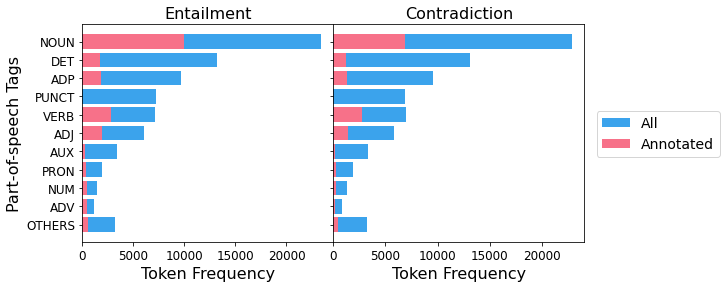

Save at .cache/2022-09-03/stats_pos_esnli_subfigs.png


In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.color_palette("husl", 3)

# Figure metadata
fig, axes = plt.subplots(1,2, figsize=(9, 4), sharey='row')
fig.subplots_adjust(hspace=0, wspace=0)

for ax, cnt_ in zip(axes, stats_reduced):

    ax.barh(list(cnt_['dataset'].keys()), list(cnt_['dataset'].values()), color = palette[2], label='All')
    ax.barh(list(cnt_['annotation'].keys()), list(cnt_['annotation'].values()), color = palette[0], label='Annotated')
    ax.set_title(cnt_['label'].capitalize(),fontsize=16)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
lines, labels = axes[0].get_legend_handles_labels() 
fig.legend(lines, labels, loc='right', ncol=1, fontsize=14,bbox_to_anchor=(1.12, .5))#

axes[0].set_ylabel('Part-of-speech Tags',fontsize=16)
axes[0].set_xlabel('Token Frequency',fontsize=16)
axes[1].set_xlabel('Token Frequency',fontsize=16)

plt.savefig(path.join(tmp_path, 'stats_pos_esnli_subfigs.png'), bbox_inches="tight", dpi=300, transparent=True)
plt.show()
print('Save at', path.join(tmp_path, 'stats_pos_esnli_subfigs.png'))

In [28]:
# Counting on different label
df = testset.data

{'annotation': {'NOUN': 20057,
  'ADP': 3767,
  'DET': 3390,
  'VERB': 6634,
  'ADJ': 4235,
  'ADV': 876,
  'AUX': 527,
  'CCONJ': 270,
  'PROPN': 611,
  'NUM': 754,
  'PART': 332,
  'SCONJ': 97,
  'PRON': 805,
  'PUNCT': 2,
  'X': 10,
  'INTJ': 10},
 'dataset': {'DET': 39607,
  'NOUN': 70019,
  'VERB': 21509,
  'ADP': 29167,
  'SCONJ': 1790,
  'PRON': 6000,
  'ADJ': 17922,
  'PUNCT': 20907,
  'AUX': 10108,
  'CCONJ': 4367,
  'ADV': 2938,
  'PART': 1543,
  'PROPN': 2272,
  'NUM': 4023,
  'INTJ': 44,
  'X': 22,
  'SPACE': 17,
  'SYM': 3}}

In [ ]:
# Load dataset

# Add punctuation to separate sentences
for i in range(len(tokens)):
    tokens[i].append('.')
    rationale[i].append(0)


# Find postag
from spacy.tokens import Doc
import spacy

flatten_token = [tk for sent in tokens for tk in sent]
flatten_rationale = [r for sent in rationale for r in sent]

nlp = spacy.load('en_core_web_sm')
doc = Doc(nlp.vocab, words=flatten_token)
pos = [tk.pos_ for tk in nlp(doc)]

Visualize the POS stastistics 

In [ ]:
#visua

# Compute Plausibility Score for Heuristic

In [3]:
from modules.logger import init_logging
from modules.logger import log
init_logging(color=True)

import platform
node = platform.node()
log.info(f'Current node: {node}')

if node == 'MAC-C02D80HRMD6':
    ROOT = '/Users/dunguyen/Developer/server_backup/historic/2023-06-05'
else: 
    ROOT = '/home/dunguyen/RUNS'
log.info(f'Root folder: {ROOT}')

10-10-2023 15:39:20 |     INFO   427789605.py:<cell line: 7>:7  Current node: grele-5.nancy.grid5000.fr
10-10-2023 15:39:20 |     INFO   427789605.py:<cell line: 13>:13  Root folder: /home/dunguyen/RUNS


In [4]:
import torchmetrics as m
import warnings

# Measure plausibility with AUPRC
warnings.filterwarnings('ignore')
auprc = m.AveragePrecision(average='micro')
auroc = m.AUROC(average='micro')    
warnings.filterwarnings('default')

In [36]:
import pandas as pd

df = pd.read_parquet(ROOT+'/dataset/esnli/test.pretransformed.parquet')
df.head()

,id,premise,hypothesis,label,explanation,highlight_premise,highlight_hypothesis,tokens.norm.premise,tokens.norm.hypothesis,rationale.premise,rationale.hypothesis,heuristic.premise,heuristic.hypothesis,tokens.form.premise,tokens.form.hypothesis
0,2677109430.jpg#1r1n,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,neutral,Not all churches have cracks in the ceiling,This church choir sings to the masses as they ...,The church has *cracks* *in* *the* *ceiling.*,"[this, church, choir, sing, to, the, masse, as...","[the, church, have, crack, in, the, ceiling, .]","[False, False, False, False, False, False, Fal...","[False, False, False, True, True, True, True, ...","[-1.0000000150474662e+30, 3.064525842666626, 1...","[-1.0000000150474662e+30, 7.628961086273193, -...","[This, church, choir, sings, to, the, masses, ...","[The, church, has, cracks, in, the, ceiling, .]"
1,2677109430.jpg#1r1e,This church choir sings to the masses as they ...,The church is filled with song.,entailment,"""Filled with song"" is a rephrasing of the ""cho...",This church *choir* *sings* *to* *the* *masses...,The church is *filled* *with* *song.*,"[this, church, choir, sing, to, the, masse, as...","[the, church, be, fill, with, song, .]","[False, False, True, True, True, True, True, F...","[False, False, False, True, True, True, False]","[-1.0000000150474662e+30, 2.79181170463562, 2....","[-1.0000000150474662e+30, 7.628961086273193, -...","[This, church, choir, sings, to, the, masses, ...","[The, church, is, filled, with, song, .]"
2,2677109430.jpg#1r1c,This church choir sings to the masses as they ...,A choir singing at a baseball game.,contradiction,A choir sing some other songs other than book ...,This church choir sings to the *masses* as the...,A choir *singing* at a *baseball* *game.*,"[this, church, choir, sing, to, the, masse, as...","[a, choir, singing, at, a, baseball, game, .]","[False, False, False, False, False, False, Tru...","[False, False, True, False, False, True, True,...","[-1.0000000150474662e+30, 2.5598974227905273, ...","[-1.0000000150474662e+30, 6.388305187225342, 6...","[This, church, choir, sings, to, the, masses, ...","[A, choir, singing, at, a, baseball, game, .]"
3,6160193920.jpg#4r1n,"A woman with a green headscarf, blue shirt and...",The woman is young.,neutral,the woman could've been old rather than young,"A woman with a green headscarf, blue shirt and...",The woman is *young.*,"[a, woman, with, a, green, headscarf, ,, blue,...","[the, woman, be, young, .]","[False, False, False, False, False, False, Fal...","[False, False, False, True, False]","[-1.0000000150474662e+30, 2.597653388977051, -...","[-1.0000000150474662e+30, 5.648240089416504, -...","[A, woman, with, a, green, headscarf, ,, blue,...","[The, woman, is, young, .]"
4,6160193920.jpg#4r1e,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,entailment,a grin suggests hapiness.,"A woman with a green headscarf, blue shirt and...",The woman is very *happy.*,"[a, woman, with, a, green, headscarf, ,, blue,...","[the, woman, be, very, happy, .]","[False, False, False, False, False, False, Fal...","[False, False, False, False, True, False]","[-1.0000000150474662e+30, 2.784580707550049, -...","[-1.0000000150474662e+30, 5.648240089416504, -...","[A, woman, with, a, green, headscarf, ,, blue,...","[The, woman, is, very, happy, .]"


In [37]:
import numpy as np
from scipy.special import softmax
from modules.utils import rescale

# Remove uneccessary columns
df = df[['id', 'label', 'heuristic.premise', 'heuristic.hypothesis', 'rationale.premise', 'rationale.hypothesis']]

# Convert numpy to list
df['rationale.premise'] = df['rationale.premise'].apply(lambda x: x.tolist())
df['rationale.hypothesis'] = df['rationale.hypothesis'].apply(lambda x: x.tolist())

# ignore neutral labels
df = df[df['label'] == 'entailment']

def rescale_heuristic(x):
    # transform to numpy array
    x = np.array(x)
    # rescale back to exponential
    x = np.exp(x)
    # normalize #TODO this step is because that heuristic was not normalized before
    x = softmax(x)
    # rescale to [0, 1]
    x = rescale(x)
    return x.tolist()

df['heuristic.premise'] = df['heuristic.premise'].apply(rescale_heuristic)
df['heuristic.hypothesis'] = df['heuristic.hypothesis'].apply(rescale_heuristic)
df['heuristic'] = df.apply(lambda x: x['heuristic.premise'] + x['heuristic.hypothesis'], axis=1)
df['rationale'] = df.apply(lambda x: x['rationale.premise'] + x['rationale.hypothesis'], axis=1)
df['rationale'] = df['rationale'].apply(lambda x: [float(_x) for _x in x])

In [31]:
import torch

for idx, row in df.iterrows():
    auprc.update(torch.tensor(row['heuristic']), torch.tensor(row['rationale']))
    
score = auprc.compute()
print(f'AUPRC: {score}')
auprc.reset()

Heuristic scores:
AUPRC: 0.39253997802734375
AUROC: 0.6837261915206909


In [38]:
import torch

for idx, row in df.iterrows():
    auroc.update(torch.tensor(row['heuristic']), torch.tensor(row['rationale']).int())
    
score = auroc.compute()
print(f'AUROC: {score}')
auroc.reset()

In [39]:
# Get model's prediction to check:
df = pd.read_json(ROOT+'/logs/lstm_attention/esnli/run=0_lstm=1/predictions/batch_inference.json')

df = df[(df['label'] != 'neutral') & (df['label'] == df['y_hat'])]
df.head()

In [34]:
import torch

# clean padding mask
df['a_hat.clean.premise'] = df.apply(lambda x: [a for a, m in zip(x['a_hat.premise'], x['padding_mask.premise']) if not m], axis=1)
df['a_hat.clean.hypothesis'] = df.apply(lambda x: [a for a, m in zip(x['a_hat.hypothesis'], x['padding_mask.hypothesis']) if not m], axis=1)
df['a_true.clean.premise'] = df.apply(lambda x: [a for a, m in zip(x['a_true.premise'], x['padding_mask.premise']) if not m], axis=1)
df['a_true.clean.hypothesis'] = df.apply(lambda x: [a for a, m in zip(x['a_true.hypothesis'], x['padding_mask.hypothesis']) if not m], axis=1)

In [41]:
for idx, row in df.iterrows():
    a_hat = row['a_hat.clean.premise'] + row['a_hat.clean.hypothesis']
    a_true = row['a_true.clean.premise'] + row['a_true.clean.hypothesis']
    auprc.update(torch.tensor(a_hat), torch.tensor(a_true))
    auroc.update(torch.tensor(a_hat), torch.tensor(a_true))
    
score = auprc.compute()
print(f'AUPRC Attetion: {score}')
auprc.reset()

score = auroc.compute()
print(f'AUROC Attention: {score}')
auroc.reset()

AUPRC Attetion: 0.4838666319847107
AUROC Attention: 0.7167083024978638
